# Overview
The purpose of this analysis is to predict synthetic inpatient hospital readmissions using logistic regression. The synthetic data was extracted from the s3 bucket in February of 2022 and is filtered to only include chronic conditions codes specified in the [30 CCW Chronic Conditions Algorithms file](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi7sPHzi6v6AhWgMVkFHRO-D4cQFnoECDAQAQ&url=https%3A%2F%2Fwww2.ccwdata.org%2Fdocuments%2F10280%2F19139421%2Fchr-chronic-condition-algorithms.pdf&usg=AOvVaw1RiMI_3UAJauCmBrA6v7Ye).
The SDOH (Social Determinants of Health) data is at the county-level. It is derived from the 2018 Social Vulnerability Index and the 2021 County Health Rankings. Additional information on the SDOH file used for this analysis can be found [here]( https://github.com/synthetichealth/synthea/pull/873).

# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from matplotlib import rcParams
matplotlib.rcParams['figure.figsize'] = (12,8)
from sklearn.metrics import confusion_matrix as cm
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load data

In [2]:
# assign data directory
DATA_DIR = Path('data')

# load beneficiary data
synthetic_bene_df = pd.read_csv(DATA_DIR / 'beneficiary_final.csv',
usecols=['BENE_ID','BENE_RACE_CD','AGE', 'BENE_SEX_IDENT_CD','FIPS_STATE_CNTY_JAN_CD'], 
dtype={"BENE_RACE_CD":"str", "FIPS_STATE_CNTY_JAN_CD":"str","FIPS_STATE_CNTY_FEB_CD":"str"}, 
sep="|", 
low_memory=False)

# load synthetic inpatient data
synthetic_inpatient_df = pd.read_csv(DATA_DIR / 'inpatient.csv', 
usecols=['BENE_ID','CLM_ID','CLM_ADMSN_DT','NCH_BENE_DSCHRG_DT','PRNCPAL_DGNS_CD'], 
sep="|", 
low_memory=False)

# assign sdoh data directory
DATA_DIR = Path('data')

# load sdoh data
sdoh_df = pd.read_csv(DATA_DIR / 'sdoh.csv',
dtype={"FIPS_CODE":"str"})

# Data cleaning

In [3]:
# create custom bins for food insecurity, servere housing cost burden, and no vehicle access sdoh columns
labels =['low', 'medium', 'high']
sdoh_df['FOOD_INSECURITY_GROUP'] = pd.cut(sdoh_df['FOOD_INSECURITY'], 3,labels=labels)
sdoh_df['SEVERE_HOUSING_COST_BURDEN_GROUP'] = pd.cut(sdoh_df['SEVERE_HOUSING_COST_BURDEN'], 3,labels=labels)
sdoh_df['NO_VEHICLE_ACCESS_GROUP'] = pd.cut(sdoh_df['NO_VEHICLE_ACCESS'], 3,labels=labels)

# remove old sdoh columns
sdoh_df.drop('FOOD_INSECURITY', axis=1, inplace=True)
sdoh_df.drop('SEVERE_HOUSING_COST_BURDEN', axis=1, inplace=True)
sdoh_df.drop('NO_VEHICLE_ACCESS', axis=1, inplace=True)

# Merge

In [4]:
# left join on BENE_ID to construct a dataframe that contains demographic variables.
synthetic_inpatient_df = pd.merge(synthetic_inpatient_df, synthetic_bene_df, on ='BENE_ID', how ="left")
print(synthetic_inpatient_df.shape)

# left join on FIPS to construct a dataframe that contains sdoh variables.
synthetic_inpatient_df = pd.merge(synthetic_inpatient_df, sdoh_df, how='left', left_on='FIPS_STATE_CNTY_JAN_CD', right_on='FIPS_CODE')
print(synthetic_inpatient_df.shape)

(39123, 9)
(39123, 19)


### Limit dataframe to chronic conditions

In [5]:
# list of valid ICD-10 Codes that classify as chronic conditions. CCW chronic conditions are defined by CMS and can be found here: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi7sPHzi6v6AhWgMVkFHRO-D4cQFnoECDAQAQ&url=https%3A%2F%2Fwww2.ccwdata.org%2Fdocuments%2F10280%2F19139421%2Fchr-chronic-condition-algorithms.pdf&usg=AOvVaw1RiMI_3UAJauCmBrA6v7Ye
valid_icds =['I230','I231','I232','I233','I234','I235','I236','I237','I238','I2101','I2102','I2109','I2111','I2119','I2121','I2129','I213','I214','I219','I21A1','I21A9','I220','I221','I222','I228','I229','G300','G301','G308','G309','C946','D460','D461','D4620','D4621','D4622','D464','D469','D46A','D46B','D46C','D46Z','D474','D500','D501','D508','D509','D510','D511','D512','D513','D518','D519','D520','D521','D528','D529','D530','D531','D532','D538','D539','D550','D551','D552','D5521','D5529','D553','D558','D559','D560','D561','D562','D563','D564','D565','D568','D569','D5700','D5701','D5702','D571','D5720','D57211','D57212','D57219','D573','D5740','D57411','D57412','D57413','D57418','D57419','D5742','D57431','D57432','D57433','D57438','D57439','D5744','D57451','D57452','D57453','D57458','D57459','D5780','D57811','D57812','D57813','D57818','D57819','D580','D581','D582','D588','D589','D590','D591','D5910','D5911','D5912','D5913','D5919','D592','D593','D594','D595','D596','D598','D599','D600','D601','D608','D609','D6101','D6109','D611','D612','D613','D61810','D61811','D61818','D6182','D6189','D619','D630','D631','D638','D640','D641','D642','D643','D644','D6481','D6489','D649','D7581','J4520','J4521','J4522','J4530','J4531','J4532','J4540','J4541','J4542','J4550','J4551','J4552','J45901','J45902','J45909','J45990','J45991','J45998','I480','I481','I4811','I4819','I482','I4820','I4821','I483','I484','I4891','N400','N401','N402','N403','C50011','C50012','C50019','C50021','C50022','C50029','C50111','C50112','C50119','C50121','C50122','C50129','C50211','C50212','C50219','C50221','C50222','C50229','C50311','C50312','C50319','C50321','C50322','C50329','C50411','C50412','C50419','C50421','C50422','C50429','C50511','C50512','C50519','C50521','C50522','C50529','C50611','C50612','C50619','C50621','C50622','C50629','C50811','C50812','C50819','C50821','C50822','C50829','C50911','C50912','C50919','C50921','C50922','C50929','D0500','D0501','D0502','D0510','D0511','D0512','D0580','D0581','D0582','D0590','D0591','D0592','Z170','Z171','Z191','Z192','Z853','Z86000','C180','C181','C182','C183','C184','C185','C186','C187','C188','C189','C19','C20','C49A4','C49A5','D010','D011','D012','Z85030','Z85038','Z85040','Z85048','C540','C541','C542','C543','C548','C549','D070','Z8542','C3400','C3401','C3402','C3410','C3411','C3412','C342','C3430','C3431','C3432','C3480','C3481','C3482','C3490','C3491','C3492','D0220','D0221','D0222','Z85110','Z85118','C61','D075','Z8546','C641','C642','C649','C651','C652','C659','C661','C662','C669','C688','C689','D0910','D0919','Z85520','Z85528','Z8553','Z8554','Z8559','E0836','E0936','E1036','E1136','E1336','H25011','H25012','H25013','H25019','H25031','H25032','H25033','H25039','H25041','H25042','H25043','H25049','H25091','H25092','H25093','H25099','H2510','H2511','H2512','H2513','H2520','H2521','H2522','H2523','H25811','H25812','H25813','H25819','H2589','H259','H26001','H26002','H26003','H26009','H26011','H26012','H26013','H26019','H26031','H26032','H26033','H26039','H26041','H26042','H26043','H26049','H26051','H26052','H26053','H26059','H26061','H26062','H26063','H26069','H2609','H26101','H26102','H26103','H26109','H26111','H26112','H26113','H26119','H26121','H26122','H26123','H26129','H26131','H26132','H26133','H26139','H2620','H26211','H26212','H26213','H26219','H26221','H26222','H26223','H26229','H2630','H2631','H2632','H2633','H2640','H26411','H26412','H26413','H26419','H26491','H26492','H26493','H26499','H268','H269','Q120','A1811','A5275','B520','E0821','E0822','E0829','E0921','E0922','E0929','E1021','E1022','E1029','E1121','E1122','E1129','E1321','E1322','E1329','I120','I129','I130','I1310','I1311','I132','K767','M1030','M10311','M10312','M10319','M10321','M10322','M10329','M10331','M10332','M10339','M10341','M10342','M10349','M10351','M10352','M10359','M10361','M10362','M10369','M10371','M10372','M10379','M1038','M1039','M3214','M3215','M3504','M350A','N010','N011','N012','N013','N014','N015','N016','N017','N018','N019','N01A','N020','N021','N022','N023','N024','N025','N026','N027','N028','N029','N02A','N030','N031','N032','N033','N034','N035','N036','N037','N038','N039','N03A','N040','N041','N042','N043','N044','N045','N046','N047','N048','N049','N04A','N050','N051','N052','N053','N054','N055','N056','N057','N058','N059','N05A','N060','N061','N062','N063','N064','N065','N066','N067','N068','N069','N06A','N070','N071','N072','N073','N074','N075','N076','N077','N078','N079','N07A','N08','N140','N141','N142','N143','N144','N150','N158','N159','N16','N181','N182','N183','N1830','N1831','N1832','N184','N185','N186','N189','N251','N2589','N259','N261','N269','N990','Q6102','Q6111','Q6119','Q612','Q613','Q614','Q615','Q618','J40','J410','J411','J418','J42','J430','J431','J432','J439','J440','J441','J449','J470','J471','J479','J982','J983','F0631','F0632','F310','F3110','F3111','F3112','F3113','F312','F3130','F3131','F3132','F314','F315','F3160','F3161','F3162','F3163','F3164','F3171','F3173','F3175','F3176','F3177','F3178','F3181','F3189','F319','F320','F321','F322','F323','F324','F325','F328','F3289','F329','F32A','F330','F331','F332','F333','F3340','F3341','F3342','F338','F339','F340','F341','F4321','F4323','E0800','E0801','E0810','E0811','E0821','E0822','E0829','E08311','E08319','E08321','E083211','E083212','E083213','E083219','E08329','E083291','E083292','E083293','E083299','E08331','E083311','E083312','E083313','E083319','E08339','E083391','E083392','E083393','E083399','E08341','E083411','E083412','E083413','E083419','E08349','E083491','E083492','E083493','E083499','E08351','E083511','E083512','E083513','E083519','E083521','E083522','E083523','E083529','E083531','E083532','E083533','E083539','E083541','E083542','E083543','E083549','E083551','E083552','E083553','E083559','E08359','E083591','E083592','E083593','E083599','E0836','E0837X1','E0837X2','E0837X3','E0837X9','E0839','E0840','E0841','E0842','E0843','E0844','E0849','E0851','E0852','E0859','E08610','E08618','E08620','E08621','E08622','E08628','E08630','E08638','E08641','E08649','E0865','E0869','E088','E089','E0900','E0901','E0910','E0911','E0921','E0922','E0929','E09311','E09319','E09321','E093211','E093212','E093213','E093219','E09329','E093291','E093292','E093293','E093299','E09331','E093311','E093312','E093313','E093319','E09339','E093391','E093392','E093393','E093399','E09341','E093411','E093412','E093413','E093419','E09349','E093491','E093492','E093493','E093499','E09351','E093511','E093512','E093513','E093519','E093521','E093522','E093523','E093529','E093531','E093532','E093533','E093539','E093541','E093542','E093543','E093549','E093551','E093552','E093553','E093559','E09359','E093591','E093592','E093593','E093599','E0936','E0937X1','E0937X2','E0937X3','E0937X9','E0939','E0940','E0941','E0942','E0943','E0944','E0949','E0951','E0952','E0959','E09610','E09618','E09620','E09621','E09622','E09628','E09630','E09638','E09641','E09649','E0965','E0969','E098','E099','E1010','E1011','E1021','E1022','E1029','E10311','E10319','E10321','E103211','E103212','E103213','E103219','E10329','E103291','E103292','E103293','E103299','E10331','E103311','E103312','E103313','E103319','E10339','E103391','E103392','E103393','E103399','E10341','E103411','E103412','E103413','E103419','E10349','E103491','E103492','E103493','E103499','E10351','E103511','E103512','E103513','E103519','E10359','E1036','E1037X1','E1037X2','E1037X3','E1037X9','E1039','E1040','E1041','E1042','E1043','E1044','E1049','E1051','E1052','E1059','E10610','E10618','E10620','E10621','E10622','E10628','E10630','E10638','E10641','E10649','E1065','E1069','E108','E109','E1100','E1101','E1110','E1111','E1121','E1122','E1129','E11311','E11319','E11321','E113211','E113212','E113213','E113219','E11329','E113291','E113292','E113293','E113299','E11331','E113311','E113312','E113313','E113319','E11339','E113391','E113392','E113393','E113399','E11341','E113411','E113412','E113413','E113419','E11349','E113491','E113492','E113493','E113499','E11351','E113511','E113512','E113513','E113519','E113521','E113522','E113523','E113529','E113531','E113532','E113533','E113539','E113541','E113542','E113543','E113549','E113551','E113552','E113553','E113559','E11359','E113591','E113592','E113593','E113599','E1136','E1137X1','E1137X2','E1137X3','E1137X9','E1139','E1140','E1141','E1142','E1143','E1144','E1149','E1151','E1152','E1159','E11610','E11618','E11620','E11621','E11622','E11628','E11630','E11638','E11641','E11649','E1165','E1169','E118','E119','E1300','E1301','E1310','E1311','E1321','E1322','E1329','E13311','E13319','E13321','E133211','E133212','E133213','E133219','E13329','E133291','E133292','E133293','E133299','E13331','E133311','E133312','E133313','E133319','E13339','E133391','E133392','E133393','E133399','E13341','E133411','E133412','E133413','E133419','E13349','E133491','E133492','E133493','E133499','E13351','E133511','E133512','E133513','E133519','E133521','E133522','E133523','E133529','E133531','E133532','E133533','E133539','E133541','E133542','E133543','E133549','E133551','E133552','E133553','E133559','E13359','E1336','E1339','E1340','E1341','E1342','E1343','E1344','E1349','E1351','E1352','E1359','E13610','E13618','E13620','E13621','E13622','E13628','E13630','E13638','E13641','E13649','E1365','E1369','E138','E139','H40011','H40012','H40013','H40019','H40021','H40022','H40023','H40029','H40041','H40042','H40043','H40049','H40051','H40052','H40053','H40059','H4010X0','H4010X1','H4010X2','H4010X3','H4010X4','H401110','H401111','H401112','H401113','H401114','H401120','H401121','H401122','H401123','H401124','H401130','H401131','H401132','H401133','H401134','H401190','H401191','H401192','H401193','H401194','H4011X0','H4011X1','H4011X2','H4011X3','H4011X4','H401210','H401211','H401212','H401213','H401214','H401220','H401221','H401222','H401223','H401224','H401230','H401231','H401232','H401233','H401234','H401290','H401291','H401292','H401293','H401294','H401310','H401311','H401312','H401313','H401314','H401320','H401321','H401322',
        'H401323','H401324','H401330','H401331','H401332','H401333','H401334','H401390','H401391','H401392','H401393','H401394','H401410','H401411','H401412','H401413','H401414','H401420','H401421','H401422','H401423','H401424','H401430','H401431','H401432','H401433','H401434','H401490','H401491','H401492','H401493','H401494','H40151','H40152','H40153','H40159','H4020X0','H4020X1','H4020X2','H4020X3','H4020X4','H40211','H40212','H40213','H40219','H402210','H402211','H402212','H402213','H402214','H402220','H402221','H402222','H402223','H402224','H402230','H402231','H402232','H402233','H402234','H402290','H402291','H402292','H402293','H402294','H40231','H40232','H40233','H40239','H40241','H40242','H40243','H40249','H4030X0','H4030X1','H4030X2','H4030X3','H4030X4','H4031X0','H4031X1','H4031X2','H4031X3','H4031X4','H4032X0','H4032X1','H4032X2','H4032X3','H4032X4','H4033X0','H4033X1','H4033X2','H4033X3','H4033X4','H4040X0','H4040X1','H4040X2','H4040X3','H4040X4','H4041X0','H4041X1','H4041X2','H4041X3','H4041X4','H4042X0','H4042X1','H4042X2','H4042X3','H4042X4','H4043X0','H4043X1','H4043X2','H4043X3','H4043X4','H4050X0','H4050X1','H4050X2','H4050X3','H4050X4','H4051X0','H4051X1','H4051X2','H4051X3','H4051X4','H4052X0','H4052X1','H4052X2','H4052X3','H4052X4','H4053X0','H4053X1','H4053X2','H4053X3','H4053X4','H4060X0','H4060X1','H4060X2','H4060X3','H4060X4','H4061X0','H4061X1','H4061X2','H4061X3','H4061X4','H4062X0','H4062X1','H4062X2','H4062X3','H4062X4','H4063X0','H4063X1','H4063X2','H4063X3','H4063X4','H40811','H40812','H40813','H40819','H40821','H40822','H40823','H40829','H40831','H40832','H40833','H40839','H4089','H409','H42','H44511','H44512','H44513','H44519','H47231','H47232','H47233','H47239','Q150','I0981','I110','I130','I132','I420','I425','I426','I427','I428','I43','I501','I5020','I5021','I5022','I5023','I5030','I5031','I5032','I5033','I5040','I5041','I5042','I5043','I50810','I50811','I50812','I50813','I50814','I5082','I5083','I5084','I5089','I509','P290','M80051A','M80052A','M80059A','M80851A','M80852A','M80859A','M84350A','M84351A','M84352A','M84353A','M84359A','M84451A','M84452A','M84453A','M84459A','M84550A','M84551A','M84552A','M84553A','M84559A','M84650A','M84651A','M84652A','M84653A','M84659A','M9701XA','M9702XA','S32301A','S32301B','S32302A','S32302B','S32309A','S32309B','S32311A','S32311B','S32312A','S32312B','S32313A','S32313B','S32314A','S32314B','S32315A','S32315B','S32316A','S32316B','S32391A','S32391B','S32392A','S32392B','S32399A','S32399B','S32401A','S32401B','S32402A','S32402B','S32409A','S32409B','S32411A','S32411B','S32412A','S32412B','S32413A','S32413B','S32414A','S32414B','S32415A','S32415B','S32416A','S32416B','S32421A','S32421B','S32422A','S32422B','S32423A','S32423B','S32424A','S32424B','S32425A','S32425B','S32426A','S32426B','S32431A','S32431B','S32432A','S32432B','S32433A','S32433B','S32434A','S32434B','S32435A','S32435B','S32436A','S32436B','S32441A','S32441B','S32442A','S32442B','S32443A','S32443B','S32444A','S32444B','S32445A','S32445B','S32446A','S32446B','S32451A','S32451B','S32452A','S32452B','S32453A','S32453B','S32454A','S32454B','S32455A','S32455B','S32456A','S32456B','S32461A','S32461B','S32462A','S32462B','S32463A','S32463B','S32464A','S32464B','S32465A','S32465B','S32466A','S32466B','S32471A','S32471B','S32472A','S32472B','S32473A','S32473B','S32474A','S32474B','S32475A','S32475B','S32476A','S32476B','S32481A','S32481B','S32482A','S32482B','S32483A','S32483B','S32484A','S32484B','S32485A','S32485B','S32486A','S32486B','S32491A','S32491B','S32492A','S32492B','S32499A','S32499B','S32501A','S32501B','S32502A','S32502B','S32509A','S32509B','S32511A','S32511B','S32512A','S32512B','S32519A','S32519B','S32591A','S32591B','S32592A','S32592B','S32599A','S32599B','S32601A','S32601B','S32602A','S32602B','S32609A','S32609B','S32611A','S32611B','S32612A','S32612B','S32613A','S32613B','S32614A','S32614B','S32615A','S32615B','S32616A','S32616B','S32691A','S32691B','S32692A','S32692B','S32699A','S32699B','S32810A','S32810B','S32811A','S32811B','S3282XA','S3282XB','S3289XA','S3289XB','S329XXA','S329XXB','S72001A','S72001B','S72001C','S72002A','S72002B','S72002C','S72009A','S72009B','S72009C','S72011A','S72011B','S72011C','S72012A','S72012B','S72012C','S72019A','S72019B','S72019C','S72021A','S72021B','S72021C','S72022A','S72022B','S72022C','S72023A','S72023B','S72023C','S72024A','S72024B','S72024C','S72025A','S72025B','S72025C','S72026A','S72026B','S72026C','S72031A','S72031B','S72031C','S72032A','S72032B','S72032C','S72033A','S72033B','S72033C','S72034A','S72034B','S72034C','S72035A','S72035B','S72035C','S72036A','S72036B','S72036C','S72041A','S72041B','S72041C','S72042A','S72042B','S72042C','S72043A','S72043B','S72043C','S72044A','S72044B','S72044C','S72045A','S72045B','S72045C','S72046A','S72046B','S72046C','S72051A','S72051B','S72051C','S72052A','S72052B','S72052C','S72059A','S72059B','S72059C','S72061A','S72061B','S72061C','S72062A','S72062B','S72062C','S72063A','S72063B','S72063C','S72064A','S72064B','S72064C','S72065A','S72065B','S72065C','S72066A','S72066B','S72066C','S72091A','S72091B','S72091C','S72092A','S72092B','S72092C','S72099A','S72099B','S72099C','S72101A','S72101B','S72101C','S72102A','S72102B','S72102C','S72109A','S72109B','S72109C','S72111A','S72111B','S72111C','S72112A','S72112B','S72112C','S72113A','S72113B','S72113C','S72114A','S72114B','S72114C','S72115A','S72115B','S72115C','S72116A','S72116B','S72116C','S72121A','S72121B','S72121C','S72122A','S72122B','S72122C','S72123A','S72123B','S72123C','S72124A','S72124B','S72124C','S72125A','S72125B','S72125C','S72126A','S72126B','S72126C','S72131A','S72131B','S72131C','S72132A','S72132B','S72132C','S72133A','S72133B','S72133C','S72134A','S72134B','S72134C','S72135A','S72135B','S72135C','S72136A','S72136B','S72136C','S72141A','S72141B','S72141C','S72142A','S72142B','S72142C','S72143A','S72143B','S72143C','S72144A','S72144B','S72144C','S72145A','S72145B','S72145C','S72146A','S72146B','S72146C','S7221XA','S7221XB','S7221XC','S7222XA','S7222XB','S7222XC','S7223XA','S7223XB','S7223XC','S7224XA','S7224XB','S7224XC','S7225XA','S7225XB','S7225XC','S7226XA','S7226XB','S7226XC','S79001A','S79002A','S79009A','S79011A','S79012A','S79019A','S79091A','S79092A','S79099A','E780','E7800','E7801','E781','E782','E783','E784','E7841','E7849','E785','H35031','H35032','H35033','H35039','I10','I110','I119','I120','I129','I130','I1310','I1311','I132','I150','I151','I152','I158','I159','I674','N262','E000','E001','E002','E009','E018','E02','E030','E031','E032','E033','E034','E038','E039','E890','I200','I201','I208','I240','I241','I248','I2510','I25110','I25111','I25118','I25119','I253','I2541','I2542','I255','I256','I25700','I25701','I25708','I25710','I25711','I25718','I25719','I25720','I25721','I25728','I25729','I25730','I25731','I25738','I25739','I25750','I25751','I25758','I25759','I25760','I25761','I25768','I25769','I25790','I25791','I25798','I25799','I25810','I25811','I25812','I2582','I2583','I2584','I2589','I259','F0150','F0151','F0280','F0281','F0390','F0391','F05','G138','G3101','G3109','G311','G312','G3183','G94','R4181','M8000XA','M80011A','M80012A','M80019A','M80021A','M80022A','M80029A','M80031A','M80032A','M80039A','M80041A','M80042A','M80049A','M80051A','M80052A','M80059A','M80061A','M80062A','M80069A','M80071A','M80072A','M80079A','M8008XA','M800AXA','M8080XA','M80811A','M80812A','M80819A','M80821A','M80822A','M80829A','M80831A','M80832A','M80839A','M80841A','M80842A','M80849A','M80851A','M80852A','M80859A','M80861A','M80862A','M80869A','M80871A','M80872A','M80879A','M8088XA','M808AXA','M810','M816','M818','G20','G2111','G2119','G213','G214','G218','G219','G3183','A0103','A0222','A065','A202','A212','A221','A310','A3701','A3711','A3781','A3791','A403','A420','A430','A481','A5004','A5484','B012','B052','B0681','B371','B380','B382','B390','B392','B400','B402','B410','B583','B59','B664','B671','B7781','B953','B960','B961','J09X1','J1000','J1001','J1008','J1100','J1108','J120','J121','J122','J123','J1281','J1282','J1289','J129','J13','J14','J150','J151','J1520','J15211','J15212','J1529','J153','J154','J155','J156','J157','J158','J159','J160','J168','J17','J180','J181','J182','J188','J189','J200','J84111','J84116','J84117','J84178','J842','J851','J95851','P230','P231','P232','P233','P234','P235','P236','P238','P239','Z8701','L4050','L4051','L4054','L4059','M0500','M05011','M05012','M05019','M05021','M05022','M05029','M05031','M05032','M05039','M05041','M05042','M05049','M05051','M05052','M05059','M05061','M05062','M05069','M05071','M05072','M05079','M0509','M0510','M05111','M05112','M05119','M05121','M05122','M05129','M05131','M05132','M05139','M05141','M05142','M05149','M05151','M05152','M05159','M05161','M05162','M05169','M05171','M05172','M05179','M0519','M0520','M05211','M05212','M05219','M05221','M05222','M05229','M05231','M05232','M05239','M05241','M05242','M05249','M05251','M05252','M05259','M05261','M05262','M05269','M05271','M05272','M05279','M0529','M0530','M05311','M05312','M05319','M05321','M05322','M05329','M05331','M05332','M05339','M05341','M05342','M05349','M05351','M05352','M05359','M05361','M05362','M05369','M05371','M05372','M05379','M0539','M0540','M05411','M05412','M05419','M05421','M05422','M05429','M05431','M05432','M05439','M05441','M05442','M05449','M05451','M05452','M05459','M05461','M05462','M05469','M05471','M05472','M05479','M0549','M0550','M05511','M05512','M05519','M05521','M05522','M05529','M05531','M05532','M05539','M05541','M05542','M05549','M05551','M05552','M05559','M05561','M05562','M05569','M05571','M05572','M05579','M0559','M0560','M05611','M05612','M05619','M05621','M05622','M05629','M05631','M05632','M05639','M05641','M05642','M05649','M05651','M05652','M05659','M05661','M05662','M05669','M05671','M05672','M05679','M0569','M0570','M05711','M05712','M05719','M05721','M05722','M05729','M05731','M05732','M05739','M05741','M05742','M05749','M05751','M05752','M05759','M05761','M05762','M05769','M05771',
        'M05772','M05779','M0579','M057A','M0580','M05811','M05812','M05819','M05821','M05822','M05829','M05831','M05832','M05839','M05841','M05842','M05849','M05851','M05852','M05859','M05861','M05862','M05869','M05871','M05872','M05879','M0589','M058A','M059','M0600','M06011','M06012','M06019','M06021','M06022','M06029','M06031','M06032','M06039','M06041','M06042','M06049','M06051','M06052','M06059','M06061','M06062','M06069','M06071','M06072','M06079','M0608','M0609','M060A','M061','M0620','M06211','M06212','M06219','M06221','M06222','M06229','M06231','M06232','M06239','M06241','M06242','M06249','M06251','M06252','M06259','M06261','M06262','M06269','M06271','M06272','M06279','M0628','M0629','M0630','M06311','M06312','M06319','M06321','M06322','M06329','M06331','M06332','M06339','M06341','M06342','M06349','M06351','M06352','M06359','M06361','M06362','M06369','M06371','M06372','M06379','M0638','M0639','M0680','M06811','M06812','M06819','M06821','M06822','M06829','M06831','M06832','M06839','M06841','M06842','M06849','M06851','M06852','M06859','M06861','M06862','M06869','M06871','M06872','M06879','M0688','M0689','M068A','M069','M0800','M08011','M08012','M08019','M08021','M08022','M08029','M08031','M08032','M08039','M08041','M08042','M08049','M08051','M08052','M08059','M08061','M08062','M08069','M08071','M08072','M08079','M0808','M0809','M080A','M081','M0820','M08211','M08212','M08219','M08221','M08222','M08229','M08231','M08232','M08239','M08241','M08242','M08249','M08251','M08252','M08259','M08261','M08262','M08269','M08271','M08272','M08279','M0828','M0829','M082A','M083','M0840','M08411','M08412','M08419','M08421','M08422','M08429','M08431','M08432','M08439','M08441','M08442','M08449','M08451','M08452','M08459','M08461','M08462','M08469','M08471','M08472','M08479','M0848','M084A','M0880','M08811','M08812','M08819','M08821','M08822','M08829','M08831','M08832','M08839','M08841','M08842','M08849','M08851','M08852','M08859','M08861','M08862','M08869','M08871','M08872','M08879','M0888','M0889','M0890','M08911','M08912','M08919','M08921','M08922','M08929','M08931','M08932','M08939','M08941','M08942','M08949','M08951','M08952','M08959','M08961','M08962','M08969','M08971','M08972','M08979','M0898','M0899','M089A','M150','M151','M152','M153','M154','M158','M159','M160','M1610','M1611','M1612','M162','M1630','M1631','M1632','M164','M1650','M1651','M1652','M166','M167','M169','M170','M1710','M1711','M1712','M172','M1730','M1731','M1732','M174','M175','M179','M180','M1810','M1811','M1812','M182','M1830','M1831','M1832','M184','M1850','M1851','M1852','M189','M19011','M19012','M19019','M19021','M19022','M19029','M19031','M19032','M19039','M19041','M19042','M19049','M19071','M19072','M19079','M1909','M19111','M19112','M19119','M19121','M19122','M19129','M19131','M19132','M19139','M19141','M19142','M19149','M19171','M19172','M19179','M19211','M19212','M19219','M19221','M19222','M19229','M19231','M19232','M19239','M19241','M19242','M19249','M19271','M19272','M19279','M1929','M1990','M1991','M1992','M1993','M450','M451','M452','M453','M454','M455','M456','M457','M458','M459','M45A0','M45A1','M45A2','M45A3','M45A4','M45A5','M45A6','M45A7','M45A8','M45AB','M4680','M4681','M4682','M4683','M4684','M4685','M4686','M4687','M4688','M4689','M4690','M4691','M4692','M4693','M4694','M4695','M4696','M4697','M4698','M4699','M47011','M47012','M47013','M47014','M47015','M47016','M47019','M47021','M47022','M47029','M4710','M4711','M4712','M4713','M4714','M4715','M4716','M4720','M4721','M4722','M4723','M4724','M4725','M4726','M4727','M4728','M47811','M47812','M47813','M47814','M47815','M47816','M47817','M47818','M47819','M47891','M47892','M47893','M47894','M47895','M47896','M47897','M47898','M47899','M479','M488X1','M488X2','M488X3','M488X4','M488X5','M488X6','M488X7','M488X8','M488X9','G450','G451','G452','G453','G458','G459','G460','G461','G462','G463','G464','G465','G466','G467','G468','G9731','G9732','I6000','I6001','I6002','I6010','I6011','I6012','I602','I6020','I6021','I6022','I6030','I6031','I6032','I604','I6050','I6051','I6052','I606','I607','I608','I609','I610','I611','I612','I613','I614','I615','I616','I618','I619','I6200','I6201','I6202','I629','I6300','I63011','I63012','I63013','I63019','I6302','I63031','I63032','I63033','I63039','I6309','I6310','I63111','I63112','I63113','I63119','I6312','I63131','I63132','I63133','I63139','I6319','I6320','I63211','I63212','I63213','I63219','I6322','I63231','I63232','I63233','I63239','I6329','I6330','I63311','I63312','I63313','I63319','I63321','I63322','I63323','I63329','I63331','I63332','I63333','I63339','I63341','I63342','I63343','I63349','I6339','I6340','I63411','I63412','I63413','I63419','I63421','I63422','I63423','I63429','I63431','I63432','I63433','I63439','I63441','I63442','I63443','I63449','I6349','I6350','I63511','I63512','I63513','I63519','I63521','I63522','I63523','I63529','I63531','I63532','I63533','I63539','I63541','I63542','I63543','I63549','I6359','I636','I638','I6381','I6389','I639','I67841','I67848','I6789','I97810','I97811','I97820','I97821']

In [6]:
# update synthetic dataframe to only contain icds from the valid_icds list
synthetic_inpatient_df = synthetic_inpatient_df[synthetic_inpatient_df['PRNCPAL_DGNS_CD'].isin(valid_icds)]

In [7]:
# assign valid icds to chronic condition categories
ami_icds=['I230','I231','I232','I233','I234','I235','I236','I237','I238','I2101','I2102','I2109','I2111','I2119','I2121','I2129','I213','I214','I219','I21A1','I21A9','I220','I221','I222','I228','I229']
ad_icds=['G300','G301','G308','G309']
anemia_icds=['C946','D460','D461','D4620','D4621','D4622','D464','D469','D46A','D46B','D46C','D46Z','D474','D500','D501','D508','D509','D510','D511','D512','D513','D518','D519','D520','D521','D528','D529','D530','D531','D532','D538','D539','D550','D551','D552','D5521','D5529','D553','D558','D559','D560','D561','D562','D563','D564','D565','D568','D569','D5700','D5701','D5702','D571','D5720','D57211','D57212','D57219','D573','D5740','D57411','D57412','D57413','D57418','D57419','D5742','D57431','D57432','D57433','D57438','D57439','D5744','D57451','D57452','D57453','D57458','D57459','D5780','D57811','D57812','D57813','D57818','D57819','D580','D581','D582','D588','D589','D590','D591','D5910','D5911','D5912','D5913','D5919','D592','D593','D594','D595','D596','D598','D599','D600','D601','D608','D609','D6101','D6109','D611','D612','D613','D61810','D61811','D61818','D6182','D6189','D619','D630','D631','D638','D640','D641','D642','D643','D644','D6481','D6489','D649','D7581']
asthma_icds=['J4520','J4521','J4522','J4530','J4531','J4532','J4540','J4541','J4542','J4550','J4551','J4552','J45901','J45902','J45909','J45990','J45991','J45998']
afib_flutter_icds=['I480','I481','I4811','I4819','I482','I4820','I4821','I483','I484','I4891']
bph_icds=['N400','N401','N402','N403']
breast_ca_icds=['C50011','C50012','C50019','C50021','C50022','C50029','C50111','C50112','C50119','C50121','C50122','C50129','C50211','C50212','C50219','C50221','C50222','C50229','C50311','C50312','C50319','C50321','C50322','C50329','C50411','C50412','C50419','C50421','C50422','C50429','C50511','C50512','C50519','C50521','C50522','C50529','C50611','C50612','C50619','C50621','C50622','C50629','C50811','C50812','C50819','C50821','C50822','C50829','C50911','C50912','C50919','C50921','C50922','C50929','D0500','D0501','D0502','D0510','D0511','D0512','D0580','D0581','D0582','D0590','D0591','D0592','Z170','Z171','Z191','Z192','Z853','Z86000']
colorectal_ca_icds=['C180','C181','C182','C183','C184','C185','C186','C187','C188','C189','C19','C20','C49A4','C49A5','D010','D011','D012','Z85030','Z85038','Z85040','Z85048']
endometrial_ca_icds=['C540','C541','C542','C543','C548','C549','D070','Z8542']
lung_ca_icds=['C3400','C3401','C3402','C3410','C3411','C3412','C342','C3430','C3431','C3432','C3480','C3481','C3482','C3490','C3491','C3492','D0220','D0221','D0222','Z85110','Z85118']
prostate_ca_icds=['C61','D075','Z8546']
urologic_ca_icds=['C641','C642','C649','C651','C652','C659','C661','C662','C669','C688','C689','D0910','D0919','Z85520','Z85528','Z8553','Z8554','Z8559']
cataract_icds=['E0836','E0936','E1036','E1136','E1336','H25011','H25012','H25013','H25019','H25031','H25032','H25033','H25039','H25041','H25042','H25043','H25049','H25091','H25092','H25093','H25099','H2510','H2511','H2512','H2513','H2520','H2521','H2522','H2523','H25811','H25812','H25813','H25819','H2589','H259','H26001','H26002','H26003','H26009','H26011','H26012','H26013','H26019','H26031','H26032','H26033','H26039','H26041','H26042','H26043','H26049','H26051','H26052','H26053','H26059','H26061','H26062','H26063','H26069','H2609','H26101','H26102','H26103','H26109','H26111','H26112','H26113','H26119','H26121','H26122','H26123','H26129','H26131','H26132','H26133','H26139','H2620','H26211','H26212','H26213','H26219','H26221','H26222','H26223','H26229','H2630','H2631','H2632','H2633','H2640','H26411','H26412','H26413','H26419','H26491','H26492','H26493','H26499','H268','H269','Q120']
ckd_icds=['A1811','A5275','B520','E0821','E0822','E0829','E0921','E0922','E0929','E1021','E1022','E1029','E1121','E1122','E1129','E1321','E1322','E1329','I120','I129','I130','I1310','I1311','I132','K767','M1030','M10311','M10312','M10319','M10321','M10322','M10329','M10331','M10332','M10339','M10341','M10342','M10349','M10351','M10352','M10359','M10361','M10362','M10369','M10371','M10372','M10379','M1038','M1039','M3214','M3215','M3504','M350A','N010','N011','N012','N013','N014','N015','N016','N017','N018','N019','N01A','N020','N021','N022','N023','N024','N025','N026','N027','N028','N029','N02A','N030','N031','N032','N033','N034','N035','N036','N037','N038','N039','N03A','N040','N041','N042','N043','N044','N045','N046','N047','N048','N049','N04A','N050','N051','N052','N053','N054','N055','N056','N057','N058','N059','N05A','N060','N061','N062','N063','N064','N065','N066','N067','N068','N069','N06A','N070','N071','N072','N073','N074','N075','N076','N077','N078','N079','N07A','N08','N140','N141','N142','N143','N144','N150','N158','N159','N16','N181','N182','N183','N1830','N1831','N1832','N184','N185','N186','N189','N251','N2589','N259','N261','N269','N990','Q6102','Q6111','Q6119','Q612','Q613','Q614','Q615','Q618']
copd_icds=['J40','J410','J411','J418','J42','J430','J431','J432','J439','J440','J441','J449','J470','J471','J479','J982','J983']
dep_bipolar_others_icds=['F0631','F0632','F310','F3110','F3111','F3112','F3113','F312','F3130','F3131','F3132','F314','F315','F3160','F3161','F3162','F3163','F3164','F3171','F3173','F3175','F3176','F3177','F3178','F3181','F3189','F319','F320','F321','F322','F323','F324','F325','F328','F3289','F329','F32A','F330','F331','F332','F333','F3340','F3341','F3342','F338','F339','F340','F341','F4321','F4323']
dm_icds=['E0800','E0801','E0810','E0811','E0821','E0822','E0829','E08311','E08319','E08321','E083211','E083212','E083213','E083219','E08329','E083291','E083292','E083293','E083299','E08331','E083311','E083312','E083313','E083319','E08339','E083391','E083392','E083393','E083399','E08341','E083411','E083412','E083413','E083419','E08349','E083491','E083492','E083493','E083499','E08351','E083511','E083512','E083513','E083519','E083521','E083522','E083523','E083529','E083531','E083532','E083533','E083539','E083541','E083542','E083543','E083549','E083551','E083552','E083553','E083559','E08359','E083591','E083592','E083593','E083599','E0836','E0837X1','E0837X2','E0837X3','E0837X9','E0839','E0840','E0841','E0842','E0843','E0844','E0849','E0851','E0852','E0859','E08610','E08618','E08620','E08621','E08622','E08628','E08630','E08638','E08641','E08649','E0865','E0869','E088','E089','E0900','E0901','E0910','E0911','E0921','E0922','E0929','E09311','E09319','E09321','E093211','E093212','E093213','E093219','E09329','E093291','E093292','E093293','E093299','E09331','E093311','E093312','E093313','E093319','E09339','E093391','E093392','E093393','E093399','E09341','E093411','E093412','E093413','E093419','E09349','E093491','E093492','E093493','E093499','E09351','E093511','E093512','E093513','E093519','E093521','E093522','E093523','E093529','E093531','E093532','E093533','E093539','E093541','E093542','E093543','E093549','E093551','E093552','E093553','E093559','E09359','E093591','E093592','E093593','E093599','E0936','E0937X1','E0937X2','E0937X3','E0937X9','E0939','E0940','E0941','E0942','E0943','E0944','E0949','E0951','E0952','E0959','E09610','E09618','E09620','E09621','E09622','E09628','E09630','E09638','E09641','E09649','E0965','E0969','E098','E099','E1010','E1011','E1021','E1022','E1029','E10311','E10319','E10321','E103211','E103212','E103213','E103219','E10329','E103291','E103292','E103293','E103299','E10331','E103311','E103312','E103313','E103319','E10339','E103391','E103392','E103393','E103399','E10341','E103411','E103412','E103413','E103419','E10349','E103491','E103492','E103493','E103499','E10351','E103511','E103512','E103513','E103519','E10359','E1036','E1037X1','E1037X2','E1037X3','E1037X9','E1039','E1040','E1041','E1042','E1043','E1044','E1049','E1051','E1052','E1059','E10610','E10618','E10620','E10621','E10622','E10628','E10630','E10638','E10641','E10649','E1065','E1069','E108','E109','E1100','E1101','E1110','E1111','E1121','E1122','E1129','E11311','E11319','E11321','E113211','E113212','E113213','E113219','E11329','E113291','E113292','E113293','E113299','E11331','E113311','E113312','E113313','E113319','E11339','E113391','E113392','E113393','E113399','E11341','E113411','E113412','E113413','E113419','E11349','E113491','E113492','E113493','E113499','E11351','E113511','E113512','E113513','E113519','E113521','E113522','E113523','E113529','E113531','E113532','E113533','E113539','E113541','E113542','E113543','E113549','E113551','E113552','E113553','E113559','E11359','E113591','E113592','E113593','E113599','E1136','E1137X1','E1137X2','E1137X3','E1137X9','E1139','E1140','E1141','E1142','E1143','E1144','E1149','E1151','E1152','E1159','E11610','E11618','E11620','E11621','E11622','E11628','E11630','E11638','E11641','E11649','E1165','E1169','E118','E119','E1300','E1301','E1310','E1311','E1321','E1322','E1329','E13311','E13319','E13321','E133211','E133212','E133213','E133219','E13329','E133291','E133292','E133293','E133299','E13331','E133311','E133312','E133313','E133319','E13339','E133391','E133392','E133393','E133399','E13341','E133411','E133412','E133413','E133419','E13349','E133491','E133492','E133493','E133499','E13351','E133511','E133512','E133513','E133519','E133521','E133522','E133523','E133529','E133531','E133532','E133533','E133539','E133541','E133542','E133543','E133549','E133551','E133552','E133553','E133559','E13359','E1336','E1339','E1340','E1341','E1342','E1343','E1344','E1349','E1351','E1352','E1359','E13610','E13618','E13620','E13621','E13622','E13628','E13630','E13638','E13641','E13649','E1365','E1369','E138','E139']
glaucoma_icds=['H40011','H40012','H40013','H40019','H40021','H40022','H40023','H40029','H40041','H40042','H40043','H40049','H40051','H40052','H40053','H40059','H4010X0','H4010X1','H4010X2','H4010X3','H4010X4','H401110','H401111','H401112','H401113','H401114','H401120','H401121','H401122','H401123','H401124','H401130','H401131','H401132','H401133','H401134','H401190','H401191','H401192','H401193','H401194','H4011X0','H4011X1','H4011X2','H4011X3','H4011X4','H401210','H401211','H401212','H401213','H401214','H401220','H401221','H401222','H401223','H401224','H401230','H401231','H401232','H401233','H401234','H401290','H401291','H401292','H401293','H401294','H401310','H401311','H401312','H401313','H401314','H401320','H401321','H401322','H401323','H401324','H401330','H401331','H401332','H401333','H401334','H401390','H401391','H401392','H401393','H401394','H401410','H401411','H401412','H401413','H401414','H401420','H401421','H401422','H401423','H401424','H401430','H401431','H401432','H401433','H401434','H401490','H401491','H401492','H401493','H401494','H40151','H40152','H40153','H40159','H4020X0','H4020X1','H4020X2','H4020X3','H4020X4','H40211','H40212','H40213','H40219','H402210','H402211','H402212','H402213','H402214','H402220','H402221','H402222','H402223','H402224','H402230','H402231','H402232','H402233','H402234','H402290','H402291','H402292','H402293','H402294','H40231','H40232','H40233','H40239','H40241','H40242','H40243','H40249','H4030X0','H4030X1','H4030X2','H4030X3','H4030X4','H4031X0','H4031X1','H4031X2','H4031X3','H4031X4','H4032X0','H4032X1','H4032X2','H4032X3','H4032X4','H4033X0','H4033X1','H4033X2','H4033X3','H4033X4','H4040X0','H4040X1','H4040X2','H4040X3','H4040X4','H4041X0','H4041X1','H4041X2','H4041X3','H4041X4','H4042X0','H4042X1','H4042X2','H4042X3','H4042X4','H4043X0','H4043X1','H4043X2','H4043X3','H4043X4','H4050X0','H4050X1','H4050X2','H4050X3','H4050X4','H4051X0','H4051X1','H4051X2','H4051X3','H4051X4','H4052X0','H4052X1','H4052X2','H4052X3','H4052X4','H4053X0','H4053X1','H4053X2','H4053X3','H4053X4','H4060X0','H4060X1','H4060X2','H4060X3','H4060X4','H4061X0','H4061X1','H4061X2','H4061X3','H4061X4','H4062X0','H4062X1','H4062X2','H4062X3','H4062X4','H4063X0','H4063X1','H4063X2','H4063X3','H4063X4','H40811','H40812','H40813','H40819','H40821','H40822','H40823','H40829','H40831','H40832','H40833','H40839','H4089','H409','H42','H44511','H44512','H44513','H44519','H47231','H47232','H47233','H47239','Q150']
hf_non_ischemic_hd_icds=['I0981','I110','I130','I132','I420','I425','I426','I427','I428','I43','I501','I5020','I5021','I5022','I5023','I5030','I5031','I5032','I5033','I5040','I5041','I5042','I5043','I50810','I50811','I50812','I50813','I50814','I5082','I5083','I5084','I5089','I509','P290']
hip_pelvic_fx_icds=['M80051A','M80052A','M80059A','M80851A','M80852A','M80859A','M84350A','M84351A','M84352A','M84353A','M84359A','M84451A','M84452A','M84453A','M84459A','M84550A','M84551A','M84552A','M84553A','M84559A','M84650A','M84651A','M84652A','M84653A','M84659A','M9701XA','M9702XA','S32301A','S32301B','S32302A','S32302B','S32309A','S32309B','S32311A','S32311B','S32312A','S32312B','S32313A','S32313B','S32314A','S32314B','S32315A','S32315B','S32316A','S32316B','S32391A','S32391B','S32392A','S32392B','S32399A','S32399B','S32401A','S32401B','S32402A','S32402B','S32409A','S32409B','S32411A','S32411B','S32412A','S32412B','S32413A','S32413B','S32414A','S32414B','S32415A','S32415B','S32416A','S32416B','S32421A','S32421B','S32422A','S32422B','S32423A','S32423B','S32424A','S32424B','S32425A','S32425B','S32426A','S32426B','S32431A','S32431B','S32432A','S32432B','S32433A','S32433B','S32434A','S32434B','S32435A','S32435B','S32436A','S32436B','S32441A','S32441B','S32442A','S32442B','S32443A','S32443B','S32444A','S32444B','S32445A','S32445B','S32446A','S32446B','S32451A','S32451B','S32452A','S32452B','S32453A','S32453B','S32454A','S32454B','S32455A','S32455B','S32456A','S32456B','S32461A','S32461B','S32462A','S32462B','S32463A','S32463B','S32464A','S32464B','S32465A','S32465B','S32466A','S32466B','S32471A','S32471B','S32472A','S32472B','S32473A','S32473B','S32474A','S32474B','S32475A','S32475B','S32476A','S32476B','S32481A','S32481B','S32482A','S32482B','S32483A','S32483B','S32484A','S32484B','S32485A','S32485B','S32486A','S32486B','S32491A','S32491B','S32492A','S32492B','S32499A','S32499B','S32501A','S32501B','S32502A','S32502B','S32509A','S32509B','S32511A','S32511B','S32512A','S32512B','S32519A','S32519B','S32591A','S32591B','S32592A','S32592B','S32599A','S32599B','S32601A','S32601B','S32602A','S32602B','S32609A','S32609B','S32611A','S32611B','S32612A','S32612B','S32613A','S32613B','S32614A','S32614B','S32615A','S32615B','S32616A','S32616B','S32691A','S32691B','S32692A','S32692B','S32699A','S32699B','S32810A','S32810B','S32811A','S32811B','S3282XA','S3282XB','S3289XA','S3289XB','S329XXA','S329XXB','S72001A','S72001B','S72001C','S72002A','S72002B','S72002C','S72009A','S72009B','S72009C','S72011A','S72011B','S72011C','S72012A','S72012B','S72012C','S72019A','S72019B','S72019C','S72021A','S72021B','S72021C','S72022A','S72022B','S72022C','S72023A','S72023B','S72023C','S72024A','S72024B','S72024C','S72025A','S72025B','S72025C','S72026A','S72026B','S72026C','S72031A','S72031B','S72031C','S72032A','S72032B','S72032C','S72033A','S72033B','S72033C','S72034A','S72034B','S72034C','S72035A','S72035B','S72035C','S72036A','S72036B','S72036C','S72041A','S72041B','S72041C','S72042A','S72042B','S72042C','S72043A','S72043B','S72043C','S72044A','S72044B','S72044C','S72045A','S72045B','S72045C','S72046A','S72046B','S72046C','S72051A','S72051B','S72051C','S72052A','S72052B','S72052C','S72059A','S72059B','S72059C','S72061A','S72061B','S72061C','S72062A','S72062B','S72062C','S72063A','S72063B','S72063C','S72064A','S72064B','S72064C','S72065A','S72065B','S72065C','S72066A','S72066B','S72066C','S72091A','S72091B','S72091C','S72092A','S72092B','S72092C','S72099A','S72099B','S72099C','S72101A','S72101B','S72101C','S72102A','S72102B','S72102C','S72109A','S72109B','S72109C','S72111A','S72111B','S72111C','S72112A','S72112B','S72112C','S72113A','S72113B','S72113C','S72114A','S72114B','S72114C','S72115A','S72115B','S72115C','S72116A','S72116B','S72116C','S72121A','S72121B','S72121C','S72122A','S72122B','S72122C','S72123A','S72123B','S72123C','S72124A','S72124B','S72124C','S72125A','S72125B','S72125C','S72126A','S72126B','S72126C','S72131A','S72131B','S72131C','S72132A','S72132B','S72132C','S72133A','S72133B','S72133C','S72134A','S72134B','S72134C','S72135A','S72135B','S72135C','S72136A','S72136B','S72136C','S72141A','S72141B','S72141C','S72142A','S72142B','S72142C','S72143A','S72143B','S72143C','S72144A','S72144B','S72144C','S72145A','S72145B','S72145C','S72146A','S72146B','S72146C','S7221XA','S7221XB','S7221XC','S7222XA','S7222XB','S7222XC','S7223XA','S7223XB','S7223XC','S7224XA','S7224XB','S7224XC','S7225XA','S7225XB','S7225XC','S7226XA','S7226XB','S7226XC','S79001A','S79002A','S79009A','S79011A','S79012A','S79019A','S79091A','S79092A','S79099A']
hlp_icds=['E780','E7800','E7801','E781','E782','E783','E784','E7841','E7849','E785']
htn_icds=['H35031','H35032','H35033','H35039','I10','I110','I119','I120','I129','I130','I1310','I1311','I132','I150','I151','I152','I158','I159','I674','N262']
ht_icds=['E000','E001','E002','E009','E018','E02','E030','E031','E032','E033','E034','E038','E039','E890']
ihd_icds=['I200','I201','I208','I240','I241','I248','I2510','I25110','I25111','I25118','I25119','I253','I2541','I2542','I255','I256','I25700','I25701','I25708','I25710','I25711','I25718','I25719','I25720','I25721','I25728','I25729','I25730','I25731','I25738','I25739','I25750','I25751','I25758','I25759','I25760','I25761','I25768','I25769','I25790','I25791','I25798','I25799','I25810','I25811','I25812','I2582','I2583','I2584','I2589','I259']
nad_icds=['F0150','F0151','F0280','F0281','F0390','F0391','F05','G138','G3101','G3109','G311','G312','G3183','G94','R4181']
or_with_without_pathological_fx_icds=['M8000XA','M80011A','M80012A','M80019A','M80021A','M80022A','M80029A','M80031A','M80032A','M80039A','M80041A','M80042A','M80049A','M80051A','M80052A','M80059A','M80061A','M80062A','M80069A','M80071A','M80072A','M80079A','M8008XA','M800AXA','M8080XA','M80811A','M80812A','M80819A','M80821A','M80822A','M80829A','M80831A','M80832A','M80839A','M80841A','M80842A','M80849A','M80851A','M80852A','M80859A','M80861A','M80862A','M80869A','M80871A','M80872A','M80879A','M8088XA','M808AXA','M810','M816','M818']
pd_and_sp_icds=['G20','G2111','G2119','G213','G214','G218','G219','G3183']
pneumonia_all_cause_icds=['A0103','A0222','A065','A202','A212','A221','A310','A3701','A3711','A3781','A3791','A403','A420','A430','A481','A5004','A5484','B012','B052','B0681','B371','B380','B382','B390','B392','B400','B402','B410','B583','B59','B664','B671','B7781','B953','B960','B961','J09X1','J1000','J1001','J1008','J1100','J1108','J120','J121','J122','J123','J1281','J1282','J1289','J129','J13','J14','J150','J151','J1520','J15211','J15212','J1529','J153','J154','J155','J156','J157','J158','J159','J160','J168','J17','J180','J181','J182','J188','J189','J200','J84111','J84116','J84117','J84178','J842','J851','J95851','P230','P231','P232','P233','P234','P235','P236','P238','P239','Z8701']
ra_oa_icds=['L4050','L4051','L4054','L4059','M0500','M05011','M05012','M05019','M05021','M05022','M05029','M05031','M05032','M05039','M05041','M05042','M05049','M05051','M05052','M05059','M05061','M05062','M05069','M05071','M05072','M05079','M0509','M0510','M05111','M05112','M05119','M05121','M05122','M05129','M05131','M05132','M05139','M05141','M05142','M05149','M05151','M05152','M05159','M05161','M05162','M05169','M05171','M05172','M05179','M0519','M0520','M05211','M05212','M05219','M05221','M05222','M05229','M05231','M05232','M05239','M05241','M05242','M05249','M05251','M05252','M05259','M05261','M05262','M05269','M05271','M05272','M05279','M0529','M0530','M05311','M05312','M05319','M05321','M05322','M05329','M05331','M05332','M05339','M05341','M05342','M05349','M05351','M05352','M05359','M05361','M05362','M05369','M05371','M05372','M05379','M0539','M0540','M05411','M05412','M05419','M05421','M05422','M05429','M05431','M05432','M05439','M05441','M05442','M05449','M05451','M05452','M05459','M05461','M05462','M05469','M05471','M05472','M05479','M0549','M0550','M05511','M05512','M05519','M05521','M05522','M05529','M05531','M05532','M05539','M05541','M05542','M05549','M05551','M05552','M05559','M05561','M05562','M05569','M05571','M05572','M05579','M0559','M0560','M05611','M05612','M05619','M05621','M05622','M05629','M05631','M05632','M05639','M05641','M05642','M05649','M05651','M05652','M05659','M05661','M05662','M05669','M05671','M05672','M05679','M0569','M0570','M05711','M05712','M05719','M05721','M05722','M05729','M05731','M05732','M05739','M05741','M05742','M05749','M05751','M05752','M05759','M05761','M05762','M05769','M05771','M05772','M05779','M0579','M057A','M0580','M05811','M05812','M05819','M05821','M05822','M05829','M05831','M05832','M05839','M05841','M05842','M05849','M05851','M05852','M05859','M05861','M05862','M05869','M05871','M05872','M05879','M0589','M058A','M059','M0600','M06011','M06012','M06019','M06021','M06022','M06029','M06031','M06032','M06039','M06041','M06042','M06049','M06051','M06052','M06059','M06061','M06062','M06069','M06071','M06072','M06079','M0608','M0609','M060A','M061','M0620','M06211','M06212','M06219','M06221','M06222','M06229','M06231','M06232','M06239','M06241','M06242','M06249','M06251','M06252','M06259','M06261','M06262','M06269','M06271','M06272','M06279','M0628','M0629','M0630','M06311','M06312','M06319','M06321','M06322','M06329','M06331','M06332','M06339','M06341','M06342','M06349','M06351','M06352','M06359','M06361','M06362','M06369','M06371','M06372','M06379','M0638','M0639','M0680','M06811','M06812','M06819','M06821','M06822','M06829','M06831','M06832','M06839','M06841','M06842','M06849','M06851','M06852','M06859','M06861','M06862','M06869','M06871','M06872','M06879','M0688','M0689','M068A','M069','M0800','M08011','M08012','M08019','M08021','M08022','M08029','M08031','M08032','M08039','M08041','M08042','M08049','M08051','M08052','M08059','M08061','M08062','M08069','M08071','M08072','M08079','M0808','M0809','M080A','M081','M0820','M08211','M08212','M08219','M08221','M08222','M08229','M08231','M08232','M08239','M08241','M08242','M08249','M08251','M08252','M08259','M08261','M08262','M08269','M08271','M08272','M08279','M0828','M0829','M082A','M083','M0840','M08411','M08412','M08419','M08421','M08422','M08429','M08431','M08432','M08439','M08441','M08442','M08449','M08451','M08452','M08459','M08461','M08462','M08469','M08471','M08472','M08479','M0848','M084A','M0880','M08811','M08812','M08819','M08821','M08822','M08829','M08831','M08832','M08839','M08841','M08842','M08849','M08851','M08852','M08859','M08861','M08862','M08869','M08871','M08872','M08879','M0888','M0889','M0890','M08911','M08912','M08919','M08921','M08922','M08929','M08931','M08932','M08939','M08941','M08942','M08949','M08951','M08952','M08959','M08961','M08962','M08969','M08971','M08972','M08979','M0898','M0899','M089A','M150','M151','M152','M153','M154','M158','M159','M160','M1610','M1611','M1612','M162','M1630','M1631','M1632','M164','M1650','M1651','M1652','M166','M167','M169','M170','M1710','M1711','M1712','M172','M1730','M1731','M1732','M174','M175','M179','M180','M1810','M1811','M1812','M182','M1830','M1831','M1832','M184','M1850','M1851','M1852','M189','M19011','M19012','M19019','M19021','M19022','M19029','M19031','M19032','M19039','M19041','M19042','M19049','M19071','M19072','M19079','M1909','M19111','M19112','M19119','M19121','M19122','M19129','M19131','M19132','M19139','M19141','M19142','M19149','M19171','M19172','M19179','M19211','M19212','M19219','M19221','M19222','M19229','M19231','M19232','M19239','M19241','M19242','M19249','M19271','M19272','M19279','M1929','M1990','M1991','M1992','M1993','M450','M451','M452','M453','M454','M455','M456','M457','M458','M459','M45A0','M45A1','M45A2','M45A3','M45A4','M45A5','M45A6','M45A7','M45A8','M45AB','M4680','M4681','M4682','M4683','M4684','M4685','M4686','M4687','M4688','M4689','M4690','M4691','M4692','M4693','M4694','M4695','M4696','M4697','M4698','M4699','M47011','M47012','M47013','M47014','M47015','M47016','M47019','M47021','M47022','M47029','M4710','M4711','M4712','M4713','M4714','M4715','M4716','M4720','M4721','M4722','M4723','M4724','M4725','M4726','M4727','M4728','M47811','M47812','M47813','M47814','M47815','M47816','M47817','M47818','M47819','M47891','M47892','M47893','M47894','M47895','M47896','M47897','M47898','M47899','M479','M488X1','M488X2','M488X3','M488X4','M488X5','M488X6','M488X7','M488X8','M488X9']
stroke_tia_icds=['G450','G451','G452','G453','G458','G459','G460','G461','G462','G463','G464','G465','G466','G467','G468','G9731','G9732','I6000','I6001','I6002','I6010','I6011','I6012','I602','I6020','I6021','I6022','I6030','I6031','I6032','I604','I6050','I6051','I6052','I606','I607','I608','I609','I610','I611','I612','I613','I614','I615','I616','I618','I619','I6200','I6201','I6202','I629','I6300','I63011','I63012','I63013','I63019','I6302','I63031','I63032','I63033','I63039','I6309','I6310','I63111','I63112','I63113','I63119','I6312','I63131','I63132','I63133','I63139','I6319','I6320','I63211','I63212','I63213','I63219','I6322','I63231','I63232','I63233','I63239','I6329','I6330','I63311','I63312','I63313','I63319','I63321','I63322','I63323','I63329','I63331','I63332','I63333','I63339','I63341','I63342','I63343','I63349','I6339','I6340','I63411','I63412','I63413','I63419','I63421','I63422','I63423','I63429','I63431','I63432','I63433','I63439','I63441','I63442','I63443','I63449','I6349','I6350','I63511','I63512','I63513','I63519','I63521','I63522','I63523','I63529','I63531','I63532','I63533','I63539','I63541','I63542','I63543','I63549','I6359','I636','I638','I6381','I6389','I639','I67841','I67848','I6789','I97810','I97811','I97820','I97821']

# rename synthetic chronic condition categories
synthetic_inpatient_df.replace(ami_icds,'ami', inplace=True)
synthetic_inpatient_df.replace(ad_icds,'ad', inplace=True)
synthetic_inpatient_df.replace(anemia_icds,'anemia', inplace=True)
synthetic_inpatient_df.replace(asthma_icds,'asthma', inplace=True)
synthetic_inpatient_df.replace(afib_flutter_icds,'afib_flutter', inplace=True)
synthetic_inpatient_df.replace(bph_icds,'bph', inplace=True)
synthetic_inpatient_df.replace(breast_ca_icds,'breast_ca', inplace=True)
synthetic_inpatient_df.replace(colorectal_ca_icds,'colorectal_ca', inplace=True)
synthetic_inpatient_df.replace(endometrial_ca_icds,'endometrial_ca', inplace=True)
synthetic_inpatient_df.replace(lung_ca_icds,'lung_ca', inplace=True)
synthetic_inpatient_df.replace(prostate_ca_icds,'prostate_ca', inplace=True)
synthetic_inpatient_df.replace(urologic_ca_icds,'urologic_ca', inplace=True)
synthetic_inpatient_df.replace(cataract_icds,'cataract', inplace=True)
synthetic_inpatient_df.replace(ckd_icds,'ckd', inplace=True)
synthetic_inpatient_df.replace(copd_icds,'copd', inplace=True)
synthetic_inpatient_df.replace(dep_bipolar_others_icds,'dep_bipolar_others', inplace=True)
synthetic_inpatient_df.replace(dm_icds,'dm', inplace=True)
synthetic_inpatient_df.replace(glaucoma_icds,'glaucoma', inplace=True)
synthetic_inpatient_df.replace(hf_non_ischemic_hd_icds,'hf_non_ischemic_hd', inplace=True)
synthetic_inpatient_df.replace(hip_pelvic_fx_icds,'hip_pelvic_fx', inplace=True)
synthetic_inpatient_df.replace(hlp_icds,'hlp', inplace=True)
synthetic_inpatient_df.replace(htn_icds,'htn', inplace=True)
synthetic_inpatient_df.replace(ht_icds,'ht', inplace=True)
synthetic_inpatient_df.replace(ihd_icds,'ihd', inplace=True)
synthetic_inpatient_df.replace(nad_icds,'nad', inplace=True)
synthetic_inpatient_df.replace(or_with_without_pathological_fx_icds,'or_with_without_pathological_fx', inplace=True)
synthetic_inpatient_df.replace(pd_and_sp_icds,'pd_and_sp', inplace=True)
synthetic_inpatient_df.replace(pneumonia_all_cause_icds,'pneumonia_all_cause', inplace=True)
synthetic_inpatient_df.replace(ra_oa_icds,'ra_oa', inplace=True)
synthetic_inpatient_df.replace(stroke_tia_icds,'stroke_tia', inplace=True)

### Convert datatypes

In [8]:
# convert synthetic dates to datetime
synthetic_inpatient_df['CLM_ADMSN_DT'] = pd.to_datetime(synthetic_inpatient_df['CLM_ADMSN_DT'])
synthetic_inpatient_df['NCH_BENE_DSCHRG_DT'] = pd.to_datetime(synthetic_inpatient_df['NCH_BENE_DSCHRG_DT'])

### Relabel columns

In [9]:
# BENE_SEX_IDENT_CD
synthetic_inpatient_df['BENE_SEX_IDENT_CD'] = synthetic_inpatient_df['BENE_SEX_IDENT_CD'].astype('category')
synthetic_inpatient_df['BENE_SEX_IDENT_CD'] = synthetic_inpatient_df['BENE_SEX_IDENT_CD'].cat.rename_categories({1: 'Male', 2: 'Female'})
print(synthetic_inpatient_df['BENE_SEX_IDENT_CD'].value_counts())

# BENE_RACE_CD
synthetic_inpatient_df['BENE_RACE_CD'] = synthetic_inpatient_df['BENE_RACE_CD'].astype('category')
synthetic_inpatient_df['BENE_RACE_CD'] = synthetic_inpatient_df['BENE_RACE_CD'].cat.rename_categories({'1': 'White', '2': 'Black', '3': 'Other', '4': 'Asian', '5': 'Hispanic', '6': 'North_American_Native'})
print(synthetic_inpatient_df['BENE_RACE_CD'].value_counts())

Female    14793
Male       6379
Name: BENE_SEX_IDENT_CD, dtype: int64
White                    12925
Hispanic                  3569
Black                     3369
Asian                      823
Other                      284
North_American_Native      202
Name: BENE_RACE_CD, dtype: int64


In [10]:
# categorize age
category = pd.cut(synthetic_inpatient_df.AGE, bins=[0,70,75,80], labels=['65-70','70-75','75-80'])
synthetic_inpatient_df.insert(5,'AGE_GROUP',category)
synthetic_inpatient_df['AGE_GROUP'].value_counts()

# drop old age column
synthetic_inpatient_df = synthetic_inpatient_df.drop('AGE', axis=1)
print(synthetic_inpatient_df['AGE_GROUP'].value_counts())

75-80    8890
70-75    6630
65-70    5652
Name: AGE_GROUP, dtype: int64


# Data exploration

In [11]:
# list columns
print(synthetic_inpatient_df.columns)

Index(['BENE_ID', 'CLM_ID', 'CLM_ADMSN_DT', 'NCH_BENE_DSCHRG_DT', 'PRNCPAL_DGNS_CD', 'AGE_GROUP', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'FIPS_STATE_CNTY_JAN_CD', 'FIPS_CODE', 'COUNTY_CODE', 'COUNTY', 'ST', 'STATE', 'UNEMPLOYED', 'UNINSURED', 'FOOD_INSECURITY_GROUP', 'SEVERE_HOUSING_COST_BURDEN_GROUP', 'NO_VEHICLE_ACCESS_GROUP'], dtype='object')


In [12]:
# obtain count of samples
print('Number of samples:', len(synthetic_inpatient_df))

Number of samples: 21172


In [13]:
# count number of unique claim ids
unique_ids = synthetic_inpatient_df['CLM_ID'].unique()

print(f"{len(unique_ids)} unique ids and {synthetic_inpatient_df.shape[0]} total rows")

15405 unique ids and 21172 total rows


# Define 30, 60, 90 day readmissions

In [14]:
# 30 days
synthetic_inpatient_df[['CLM_ADMSN_DT','NCH_BENE_DSCHRG_DT']] = synthetic_inpatient_df[['CLM_ADMSN_DT','NCH_BENE_DSCHRG_DT']].\
                                                apply(lambda x: pd.to_datetime(x))
synthetic_inpatient_df = synthetic_inpatient_df.sort_values(['BENE_ID','CLM_ADMSN_DT'])
synthetic_inpatient_df['READMIT_30']=synthetic_inpatient_df.groupby('BENE_ID').apply(lambda x : (x['CLM_ADMSN_DT'].\
shift(-1)-x['NCH_BENE_DSCHRG_DT']).dt.days.le(30).astype(int)).reset_index(0).drop('BENE_ID',1)


# 60 days
synthetic_inpatient_df[['CLM_ADMSN_DT','NCH_BENE_DSCHRG_DT']] = synthetic_inpatient_df[['CLM_ADMSN_DT','NCH_BENE_DSCHRG_DT']].\
                                                apply(lambda x: pd.to_datetime(x))
synthetic_inpatient_df = synthetic_inpatient_df.sort_values(['BENE_ID','CLM_ADMSN_DT'])
synthetic_inpatient_df['READMIT_60']=synthetic_inpatient_df.groupby('BENE_ID').apply(lambda x : (x['CLM_ADMSN_DT'].\
shift(-1)-x['NCH_BENE_DSCHRG_DT']).dt.days.le(60).astype(int)).reset_index(0).drop('BENE_ID',1)


# 90 days
synthetic_inpatient_df[['CLM_ADMSN_DT','NCH_BENE_DSCHRG_DT']] = synthetic_inpatient_df[['CLM_ADMSN_DT','NCH_BENE_DSCHRG_DT']].\
                                                apply(lambda x: pd.to_datetime(x))
synthetic_inpatient_df = synthetic_inpatient_df.sort_values(['BENE_ID','CLM_ADMSN_DT'])
synthetic_inpatient_df['READMIT_90']=synthetic_inpatient_df.groupby('BENE_ID').apply(lambda x : (x['CLM_ADMSN_DT'].\
shift(-1)-x['NCH_BENE_DSCHRG_DT']).dt.days.le(90).astype(int)).reset_index(0).drop('BENE_ID',1)

/var/folders/10/blw3wx910qzccf4vdz5gsj4h0000gp/T/ipykernel_12880/3572717606.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  shift(-1)-x['NCH_BENE_DSCHRG_DT']).dt.days.le(30).astype(int)).reset_index(0).drop('BENE_ID',1)
/var/folders/10/blw3wx910qzccf4vdz5gsj4h0000gp/T/ipykernel_12880/3572717606.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  shift(-1)-x['NCH_BENE_DSCHRG_DT']).dt.days.le(60).astype(int)).reset_index(0).drop('BENE_ID',1)
/var/folders/10/blw3wx910qzccf4vdz5gsj4h0000gp/T/ipykernel_12880/3572717606.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  shift(-1)-x['NCH_BENE_DSCHRG_DT']).dt.days.le(90).astype(int)).reset_index(0).drop('BENE_ID',1)


In [15]:
# define output label
synthetic_inpatient_df['OUTPUT_LABEL_30'] = (synthetic_inpatient_df.READMIT_30 == 1).astype('int')
synthetic_inpatient_df['OUTPUT_LABEL_60'] = (synthetic_inpatient_df.READMIT_60 == 1).astype('int')
synthetic_inpatient_df['OUTPUT_LABEL_90'] = (synthetic_inpatient_df.READMIT_90 == 1).astype('int')

In [16]:
# calculate the prevalence of readmissions
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

print('Prevalence:%.3f'%calc_prevalence(synthetic_inpatient_df['OUTPUT_LABEL_30'].values))
print('Prevalence:%.3f'%calc_prevalence(synthetic_inpatient_df['OUTPUT_LABEL_60'].values))
print('Prevalence:%.3f'%calc_prevalence(synthetic_inpatient_df['OUTPUT_LABEL_90'].values))

Prevalence:0.557
Prevalence:0.586
Prevalence:0.597


# Feature Engineering

In [17]:
# define categorical variables
cols_cat = ['BENE_SEX_IDENT_CD','PRNCPAL_DGNS_CD', 'AGE_GROUP','FOOD_INSECURITY_GROUP','SEVERE_HOUSING_COST_BURDEN_GROUP','NO_VEHICLE_ACCESS_GROUP']

In [18]:
# check for missing values in categorical variables
synthetic_inpatient_df[cols_cat].isnull().sum()

BENE_SEX_IDENT_CD                      0
PRNCPAL_DGNS_CD                        0
AGE_GROUP                              0
FOOD_INSECURITY_GROUP               4867
SEVERE_HOUSING_COST_BURDEN_GROUP    4867
NO_VEHICLE_ACCESS_GROUP             4867
dtype: int64

In [19]:
# convert sdoh fiels to object
synthetic_inpatient_df['FOOD_INSECURITY_GROUP'] = synthetic_inpatient_df['FOOD_INSECURITY_GROUP'].astype(object)
synthetic_inpatient_df['SEVERE_HOUSING_COST_BURDEN_GROUP'] = synthetic_inpatient_df['SEVERE_HOUSING_COST_BURDEN_GROUP'].astype(object)
synthetic_inpatient_df['NO_VEHICLE_ACCESS_GROUP'] = synthetic_inpatient_df['NO_VEHICLE_ACCESS_GROUP'].astype(object)

In [20]:
# print value counts for each group
print(synthetic_inpatient_df['BENE_SEX_IDENT_CD'].value_counts())
print(synthetic_inpatient_df['PRNCPAL_DGNS_CD'].value_counts())
print(synthetic_inpatient_df['AGE_GROUP'].value_counts())
print(synthetic_inpatient_df['FOOD_INSECURITY_GROUP'].value_counts())
print(synthetic_inpatient_df['SEVERE_HOUSING_COST_BURDEN_GROUP'].value_counts())
print(synthetic_inpatient_df['NO_VEHICLE_ACCESS_GROUP'].value_counts())

Female    14793
Male       6379
Name: BENE_SEX_IDENT_CD, dtype: int64
breast_ca                          11580
hlp                                 2290
anemia                              1538
dm                                   847
colorectal_ca                        712
ra_oa                                621
stroke_tia                           465
htn                                  453
lung_ca                              419
copd                                 389
or_with_without_pathological_fx      387
ckd                                  281
asthma                               279
ad                                   202
nad                                  182
ihd                                  140
hf_non_ischemic_hd                   127
pneumonia_all_cause                  100
afib_flutter                          98
ht                                    39
ami                                   18
dep_bipolar_others                     5
Name: PRNCPAL_DGNS_CD, dtype

In [21]:
# drop due to low sample size
# synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'ihd']
synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'afib_flutter']
synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'pneumonia_all_cause']
synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'ht']
synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'ami']
synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'dep_bipolar_others']

# drop lung_ca
# 99% of lung_ca rows indiciated readmission within 60 and 90 days
synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'lung_ca' ]

# drop due to low sample size in real data
synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'nad']
synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'hlp']
synthetic_inpatient_df = synthetic_inpatient_df.loc[synthetic_inpatient_df["PRNCPAL_DGNS_CD"] != 'or_with_without_pathological_fx']

In [22]:
# create categorical features using dummy encoding
synthetic_df_cat = pd.get_dummies(synthetic_inpatient_df[cols_cat])

# add one-hot encoding to dataframe
synthetic_inpatient_df = pd.concat([synthetic_inpatient_df,synthetic_df_cat], axis=1)

# save names of categorical data
synthetic_cols_all_cat = list(synthetic_df_cat.columns)

# define cols to use
synthetic_col2use = synthetic_cols_all_cat

# combine predictors and output variables
synthetic_df_data_30 = synthetic_inpatient_df[synthetic_col2use + ['OUTPUT_LABEL_30']]
synthetic_df_data_60 = synthetic_inpatient_df[synthetic_col2use + ['OUTPUT_LABEL_60']]
synthetic_df_data_90 = synthetic_inpatient_df[synthetic_col2use + ['OUTPUT_LABEL_90']]

In [23]:
# customize reference groups
synthetic_df_data_30 = synthetic_df_data_30.drop(['BENE_SEX_IDENT_CD_Female','PRNCPAL_DGNS_CD_dm','AGE_GROUP_75-80','FOOD_INSECURITY_GROUP_high','SEVERE_HOUSING_COST_BURDEN_GROUP_high','NO_VEHICLE_ACCESS_GROUP_high'], axis='columns')
synthetic_df_data_60 = synthetic_df_data_60.drop(['BENE_SEX_IDENT_CD_Female','PRNCPAL_DGNS_CD_dm','AGE_GROUP_75-80','FOOD_INSECURITY_GROUP_high','SEVERE_HOUSING_COST_BURDEN_GROUP_high','NO_VEHICLE_ACCESS_GROUP_high'], axis='columns')
synthetic_df_data_90 = synthetic_df_data_90.drop(['BENE_SEX_IDENT_CD_Female','PRNCPAL_DGNS_CD_dm','AGE_GROUP_75-80','FOOD_INSECURITY_GROUP_high','SEVERE_HOUSING_COST_BURDEN_GROUP_high','NO_VEHICLE_ACCESS_GROUP_high'], axis='columns')

In [24]:
list(synthetic_df_data_30)

['BENE_SEX_IDENT_CD_Male',
 'PRNCPAL_DGNS_CD_ad',
 'PRNCPAL_DGNS_CD_anemia',
 'PRNCPAL_DGNS_CD_asthma',
 'PRNCPAL_DGNS_CD_breast_ca',
 'PRNCPAL_DGNS_CD_ckd',
 'PRNCPAL_DGNS_CD_colorectal_ca',
 'PRNCPAL_DGNS_CD_copd',
 'PRNCPAL_DGNS_CD_hf_non_ischemic_hd',
 'PRNCPAL_DGNS_CD_htn',
 'PRNCPAL_DGNS_CD_ihd',
 'PRNCPAL_DGNS_CD_ra_oa',
 'PRNCPAL_DGNS_CD_stroke_tia',
 'AGE_GROUP_65-70',
 'AGE_GROUP_70-75',
 'FOOD_INSECURITY_GROUP_low',
 'FOOD_INSECURITY_GROUP_medium',
 'SEVERE_HOUSING_COST_BURDEN_GROUP_low',
 'SEVERE_HOUSING_COST_BURDEN_GROUP_medium',
 'NO_VEHICLE_ACCESS_GROUP_low',
 'NO_VEHICLE_ACCESS_GROUP_medium',
 'OUTPUT_LABEL_30']

In [25]:
# define x and y
synthetic_x_30 = synthetic_df_data_30[[
 'BENE_SEX_IDENT_CD_Male',
 'PRNCPAL_DGNS_CD_ad',
 'PRNCPAL_DGNS_CD_anemia',
 'PRNCPAL_DGNS_CD_asthma',
 'PRNCPAL_DGNS_CD_breast_ca',
 'PRNCPAL_DGNS_CD_ckd',
 'PRNCPAL_DGNS_CD_colorectal_ca',
 'PRNCPAL_DGNS_CD_copd',
 'PRNCPAL_DGNS_CD_hf_non_ischemic_hd',
 'PRNCPAL_DGNS_CD_htn',
 'PRNCPAL_DGNS_CD_ihd',
 'PRNCPAL_DGNS_CD_ra_oa',
 'PRNCPAL_DGNS_CD_stroke_tia',
 'AGE_GROUP_65-70',
 'AGE_GROUP_70-75',
 'FOOD_INSECURITY_GROUP_low',
 'FOOD_INSECURITY_GROUP_medium',
 'SEVERE_HOUSING_COST_BURDEN_GROUP_low',
 'SEVERE_HOUSING_COST_BURDEN_GROUP_medium',
 'NO_VEHICLE_ACCESS_GROUP_low',
 'NO_VEHICLE_ACCESS_GROUP_medium'        
 ]]

synthetic_y_30 = synthetic_df_data_30['OUTPUT_LABEL_30']

In [26]:
# define x and y
synthetic_x_60 = synthetic_df_data_60[[
 'BENE_SEX_IDENT_CD_Male',
 'PRNCPAL_DGNS_CD_ad',
 'PRNCPAL_DGNS_CD_anemia',
 'PRNCPAL_DGNS_CD_asthma',
 'PRNCPAL_DGNS_CD_breast_ca',
 'PRNCPAL_DGNS_CD_ckd',
 'PRNCPAL_DGNS_CD_colorectal_ca',
 'PRNCPAL_DGNS_CD_copd',
 'PRNCPAL_DGNS_CD_hf_non_ischemic_hd',
 'PRNCPAL_DGNS_CD_htn',
 'PRNCPAL_DGNS_CD_ihd',
 'PRNCPAL_DGNS_CD_ra_oa',
 'PRNCPAL_DGNS_CD_stroke_tia',
 'AGE_GROUP_65-70',
 'AGE_GROUP_70-75',
 'FOOD_INSECURITY_GROUP_low',
 'FOOD_INSECURITY_GROUP_medium',
 'SEVERE_HOUSING_COST_BURDEN_GROUP_low',
 'SEVERE_HOUSING_COST_BURDEN_GROUP_medium',
 'NO_VEHICLE_ACCESS_GROUP_low',
 'NO_VEHICLE_ACCESS_GROUP_medium'
 ]]         

synthetic_y_60 = synthetic_df_data_60['OUTPUT_LABEL_60']

In [27]:
# define x and y
synthetic_x_90 = synthetic_df_data_90[[
 'BENE_SEX_IDENT_CD_Male',
 'PRNCPAL_DGNS_CD_ad',
 'PRNCPAL_DGNS_CD_anemia',
 'PRNCPAL_DGNS_CD_asthma',
 'PRNCPAL_DGNS_CD_breast_ca',
 'PRNCPAL_DGNS_CD_ckd',
 'PRNCPAL_DGNS_CD_colorectal_ca',
 'PRNCPAL_DGNS_CD_copd',
 'PRNCPAL_DGNS_CD_hf_non_ischemic_hd',
 'PRNCPAL_DGNS_CD_htn',
 'PRNCPAL_DGNS_CD_ihd',
 'PRNCPAL_DGNS_CD_ra_oa',
 'PRNCPAL_DGNS_CD_stroke_tia',
 'AGE_GROUP_65-70',
 'AGE_GROUP_70-75',
 'FOOD_INSECURITY_GROUP_low',
 'FOOD_INSECURITY_GROUP_medium',
 'SEVERE_HOUSING_COST_BURDEN_GROUP_low',
 'SEVERE_HOUSING_COST_BURDEN_GROUP_medium',
 'NO_VEHICLE_ACCESS_GROUP_low',
 'NO_VEHICLE_ACCESS_GROUP_medium'
 ]]         

synthetic_y_90 = synthetic_df_data_90['OUTPUT_LABEL_90']

# Implement logit models and calculate odds ratios

In [28]:
# 30 day readmissions
# synthetic coefficients and odds ratios
# The default alpha = .05 returns a 95% confidence interval.
logit_model=sm.Logit(synthetic_y_30,synthetic_x_30)
result=logit_model.fit()
print(result.summary2())

odds_ratios = pd.DataFrame(
    {
        "OR": result.params,
        "Lower CI": result.conf_int()[0],
        "Upper CI": result.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)


Optimization terminated successfully.
         Current function value: 0.620981
         Iterations 7
                                    Results: Logit
Model:                      Logit                   Pseudo R-squared:        0.089     
Dependent Variable:         OUTPUT_LABEL_30         AIC:                     21942.7683
Date:                       2022-11-22 11:01        BIC:                     22106.0976
No. Observations:           17634                   Log-Likelihood:          -10950.   
Df Model:                   20                      LL-Null:                 -12017.   
Df Residuals:               17613                   LLR p-value:             0.0000    
Converged:                  1.0000                  Scale:                   1.0000    
No. Iterations:             7.0000                                                     
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err

In [29]:
# 60 day readmissions
# synthetic coefficients and odds ratios
logit_model=sm.Logit(synthetic_y_60,synthetic_x_60)
result=logit_model.fit()
print(result.summary2())

odds_ratios = pd.DataFrame(
    {
        "OR": result.params,
        "Lower CI": result.conf_int()[0],
        "Upper CI": result.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.624692
         Iterations 7
                                     Results: Logit
Model:                       Logit                   Pseudo R-squared:        0.076     
Dependent Variable:          OUTPUT_LABEL_60         AIC:                     22073.6508
Date:                        2022-11-22 11:01        BIC:                     22236.9800
No. Observations:            17634                   Log-Likelihood:          -11016.   
Df Model:                    20                      LL-Null:                 -11922.   
Df Residuals:                17613                   LLR p-value:             0.0000    
Converged:                   1.0000                  Scale:                   1.0000    
No. Iterations:              7.0000                                                     
----------------------------------------------------------------------------------------
                                         Coef

In [30]:
# 90 day readmissions
# synthetic coefficients and odds ratios
logit_model=sm.Logit(synthetic_y_90,synthetic_x_90)
result=logit_model.fit()
print(result.summary2())

odds_ratios = pd.DataFrame(
    {
        "OR": result.params,
        "Lower CI": result.conf_int()[0],
        "Upper CI": result.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.624026
         Iterations 7
                                     Results: Logit
Model:                       Logit                   Pseudo R-squared:        0.072     
Dependent Variable:          OUTPUT_LABEL_90         AIC:                     22050.1388
Date:                        2022-11-22 11:01        BIC:                     22213.4681
No. Observations:            17634                   Log-Likelihood:          -11004.   
Df Model:                    20                      LL-Null:                 -11862.   
Df Residuals:                17613                   LLR p-value:             0.0000    
Converged:                   1.0000                  Scale:                   1.0000    
No. Iterations:              7.0000                                                     
----------------------------------------------------------------------------------------
                                         Coef

# Check assumptions


2
                                  Attribute  VIF Scores
0                    BENE_SEX_IDENT_CD_Male    0.002807
1                        PRNCPAL_DGNS_CD_ad    1.063419
2                    PRNCPAL_DGNS_CD_anemia    0.002066
3                    PRNCPAL_DGNS_CD_asthma    0.090206
4                 PRNCPAL_DGNS_CD_breast_ca    0.018571
5                       PRNCPAL_DGNS_CD_ckd    0.100646
6             PRNCPAL_DGNS_CD_colorectal_ca    0.343866
7                      PRNCPAL_DGNS_CD_copd    0.407723
8        PRNCPAL_DGNS_CD_hf_non_ischemic_hd    1.045036
9                       PRNCPAL_DGNS_CD_htn    0.491211
10                      PRNCPAL_DGNS_CD_ihd    1.067520
11                    PRNCPAL_DGNS_CD_ra_oa    0.204704
12               PRNCPAL_DGNS_CD_stroke_tia    0.527754
13                          AGE_GROUP_65-70    0.078156
14                          AGE_GROUP_70-75    0.018646
15                FOOD_INSECURITY_GROUP_low    0.557150
16             FOOD_INSECURITY_GROUP_medium   

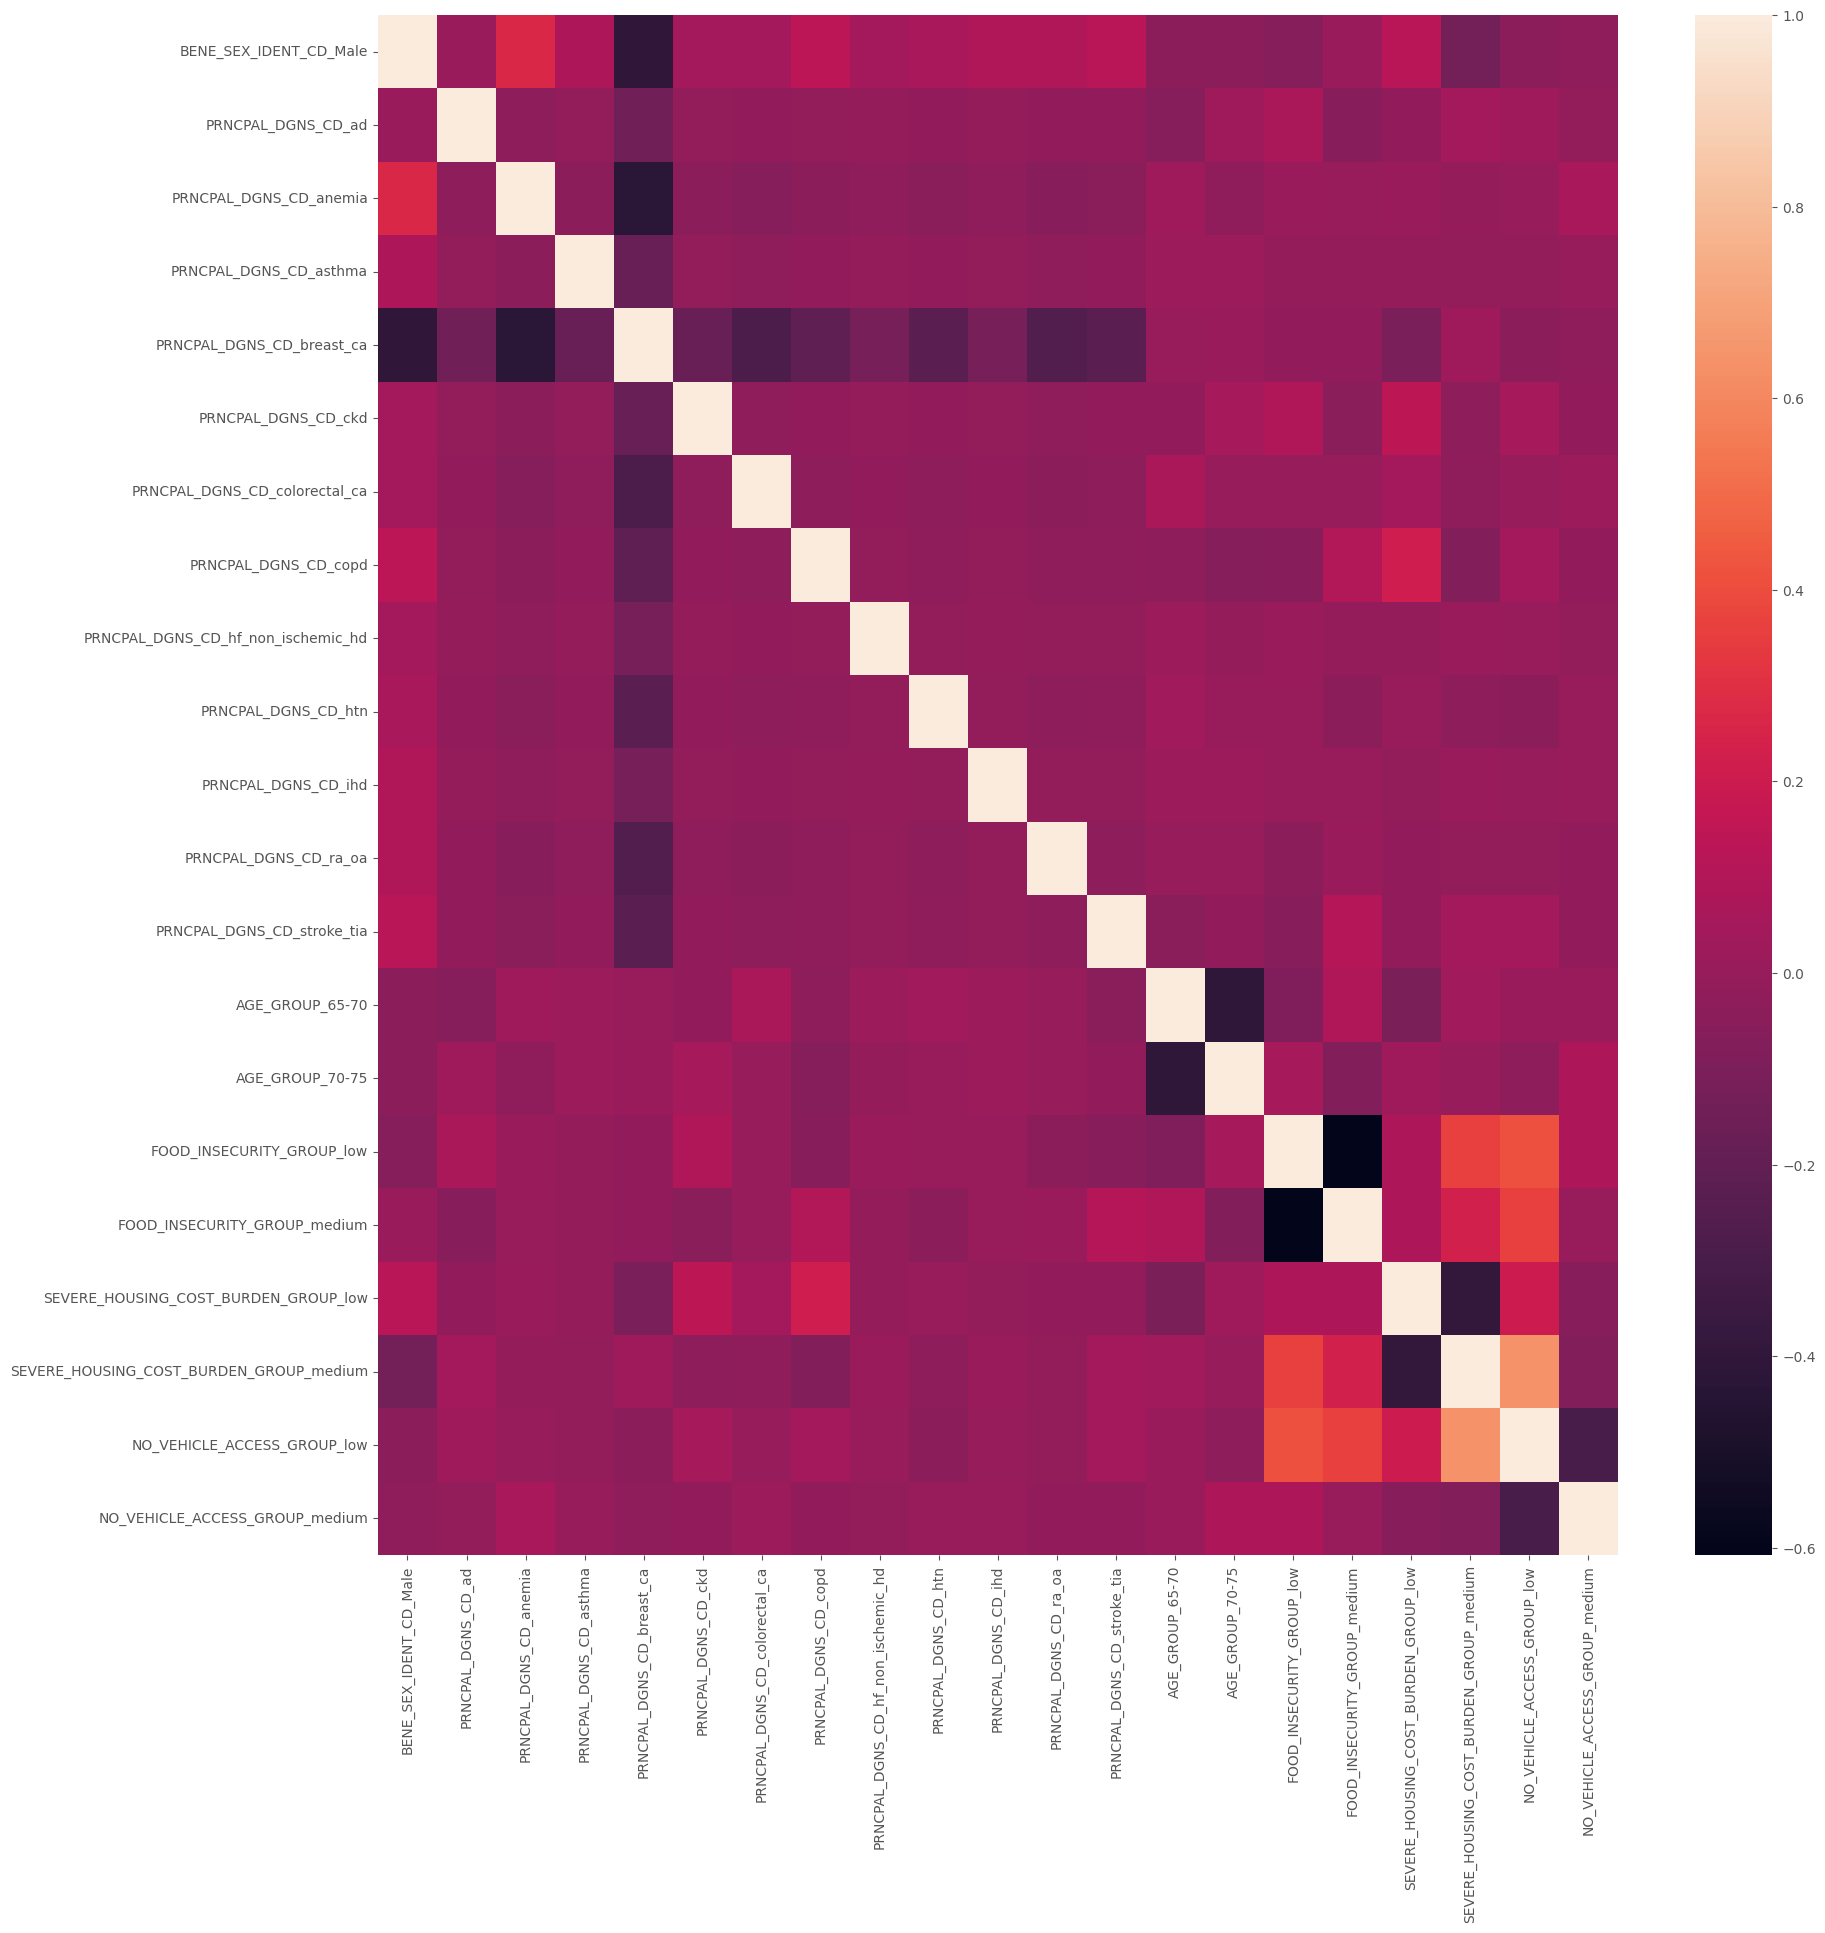

In [31]:
# 1. Appropriate outcome type
print(synthetic_df_data_30['OUTPUT_LABEL_30'].nunique())

# 2. Absence of multicollinearity
# VIF: Variance Inflation Factor
# Estimates how much variance (the square of the standar error) of a coefficient is "inflated" because of linear dependence on other predictors.
# Diagnose multicollinearity calculated by performing a linear regression of a predictor on all other predictors then obtaining the R^2 from the regression. VIF = 1/(1-R^2)
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = synthetic_x_90.columns 
vif_scores["VIF Scores"] = [variance_inflation_factor(synthetic_x_90.values, i) for i in range(len(synthetic_x_90.columns))] 
print(vif_scores)
# display correlation matrix
fig, ax = plt.subplots(figsize=(20,20)) 
synthetic_corr = sns.heatmap(synthetic_x_90.corr(),annot = False)

# 3. Sufficiently large sample size        
print(len(synthetic_inpatient_df))